# Integration human
In this notebook, scVI is used to integrate the data and a hierarchy tree is generated based on it. The scVI integration in this notebook was only used to try out the functions and better understand the process. If you want to integrate with scVI please look at the scvi python script that can be ran as a SLURM job. There is also a scHPL script that can be used to run as SLURM job. Lastly labels are harmonized based on the hierarchy (I made a function of this in the script folder so it is easier to do). This notebook contains the following major parts:
- scVI
- scHPL
- Label Harmonization

### Loading libraries
Using scarches

In [1]:
import sys
print(sys.executable)

print(sys.version)
print(sys.version_info)


/home/hers_basak/jjiang/jack/miniconda/envs/scarches2/bin/python
3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
sys.version_info(major=3, minor=9, micro=18, releaselevel='final', serial=0)


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))#embed HTML within IPython notebook and make containers 90% of screen
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import copy as cp
import seaborn as sns
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

%matplotlib inline
#scvi.settings.seed = 0
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white') #figure resolution and background color


/home/hers_basak/jjiang/jack/miniconda/envs/scarches2/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/hers_basak/jjiang/jack/miniconda/envs/scarches2/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/hers_basak/jjiang/jack/miniconda/envs/scarches2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [3]:
adata_integrated=sc.read_h5ad('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final/adata_predicted_lowest.h5ad')

In [4]:
adata_integrated

AnnData object with n_obs × n_vars = 522220 × 2000
    obs: 'species', 'gender', 'age', 'instrument', 'technology', 'atlas', 'sample', 'batch_1', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'total_counts_mito', 'total_counts_norm', 'original_Library', 'original_Brain_Region', 'original_Level_1_cell_type', 'original_Level_2_cell_type', 'original_cellclass_lvl1', 'original_subclass_lvl3_1', 'original_cellclass_lvl1_n', 'original_lineage', 'original_subclass_lvl2', 'original_celltype_lvl3', 'donor', 'original_supercluster_term', 'original_cluster_id', 'original_subcluster_id', 'original_celltype', 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_low_res', 'cell_type_high_res', 'harmonized_cell_type', 'harmonized_lowes

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)
#To make reproducible plots
np.random.seed(41)

In [6]:
#set data path
os.chdir('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/')
sc.settings.figdir = '/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scarches/'
np.random.seed(41)

In [5]:
files=['/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/complete_base.h5ad']
names=['known']

In [ ]:
object_names_merged=list()
numberobj = len(files)

for i in range(numberobj):
    object_names_merged.append("adata"+"_"+names[i])
    locals()[object_names_merged[i]] = sc.read_h5ad(files[i]) 
    print(object_names_merged[i],' is loaded')

In [ ]:
for i in range(numberobj):
    print(locals()[object_names_merged[i]])

Combine all datasets to one adata object for SCVI and combine the atlas specific celltype annotations

In [ ]:
adata_known.obs=adata_known.obs.astype(str)
adata_known.obs=adata_known.obs.replace('nan','')
adata_known.obs=adata_known.obs.replace('None','')
adata_known.obs["cell_type_lvl1"] = adata_known.obs["original_cellclass_lvl1"] +adata_known.obs["original_celltype"] +adata_known.obs["original_Level_1_cell_type"]+adata_known.obs["original_supercluster_term"]
adata_known.obs["cell_type_lvl2"] = adata_known.obs["original_subclass_lvl2"] + adata_known.obs["original_Level_2_cell_type"]+adata_known.obs["original_cluster_id"]
adata_known.obs["cell_type_lvl3"] = adata_known.obs["original_celltype_lvl3"]+adata_known.obs["original_subcluster_id"]


filter out all cells without label

In [ ]:

adata_known= adata_known[adata_known.obs['cell_type_lvl1'] != '']

In [ ]:
adata_known.obs['cell_type_lvl1']

"For a better model performance it is necessary to select HVGs. We are doing this by applying the scanpy.pp function highly_variable_genes(). The n_top_genes is set to 2000 here. However, if you have more complicated datasets you might have to increase number of genes to capture more diversity in the data."

Already cell level normalized, this is consistent for all so no extra step needed, perhaps will change in future.

In [11]:
#sc.pp.normalize_total(source_adata)

taking hvg might delete some important markers, but apparently better for model performance. first just follow the instruction with higher n genes as described in Lueken and Theis, 2019 (1k-6k). (default is 2k)

In [12]:

sc.pp.highly_variable_genes(
    adata_known,
    n_top_genes=4000,
    batch_key="atlas",
    subset=True)

"For consistency we set adata.X to be raw counts. In other datasets that may be already the case" -> whats point of normalization... (aaah we normalize to get hvg but dont actually want to use normalized data, because scvi doesnt work on that)

In [14]:
adata_known.X = adata_known.raw[:, adata_known.var_names].X

In [15]:
adata_known.write('./data/complete_labelled.h5ad')

# Create scVI model and train it on reference dataset

In [18]:
source_adata=sc.read_h5ad('./complete_labelled.h5ad')

In [21]:
print(source_adata.X)

  (0, 2114)	2
  (0, 492)	8
  (0, 2161)	44
  (0, 877)	1
  (0, 2614)	1
  (0, 3743)	1
  (0, 2032)	7
  (0, 1561)	2
  (0, 1364)	12
  (0, 1859)	7
  (0, 892)	1
  (0, 2633)	2
  (0, 567)	3
  (0, 1540)	6
  (0, 2502)	2
  (0, 1418)	26
  (0, 2250)	1
  (0, 2508)	18
  (0, 548)	3
  (0, 1433)	3
  (0, 2994)	1
  (0, 1685)	2
  (0, 3475)	1
  (0, 3474)	1
  (0, 2616)	6
  :	:
  (378208, 883)	1
  (378208, 1021)	1
  (378208, 1041)	2
  (378208, 3877)	1
  (378208, 2186)	1
  (378208, 3297)	1
  (378208, 929)	1
  (378208, 3278)	1
  (378208, 840)	1
  (378208, 1024)	1
  (378208, 1724)	2
  (378208, 3210)	1
  (378208, 3318)	1
  (378208, 3292)	1
  (378208, 1502)	1
  (378208, 3737)	1
  (378208, 3770)	4
  (378208, 3282)	1
  (378208, 3320)	1
  (378208, 1402)	1
  (378208, 1831)	1
  (378208, 2857)	1
  (378208, 1483)	1
  (378208, 882)	1
  (378208, 715)	1


In [8]:
sca.models.SCVI.setup_anndata(source_adata, batch_key="atlas")

The scVI model uses the zero-inflated negative binomial (ZINB) loss by default. Insert gene_likelihood='nb' to change the reconstruction loss to negative binomial (NB) loss.

In [9]:
vae = sca.models.SCVI(
    source_adata,
    n_latent=50,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none"
)

In [10]:
vae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

The model learns the latent representation of the anndata by minimizing the ZINB loss, essentially reducing its dimensionality.

In [11]:
vae.train()#max_epochs=20)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 21/21: 100%|██████████| 21/21 [1:13:49<00:00, 209.96s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.24e+3]

INFO: `Trainer.fit` stopped: `max_epochs=21` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=21` reached.


Epoch 21/21: 100%|██████████| 21/21 [1:13:50<00:00, 210.95s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.24e+3]


In [12]:
vae.save('./data/scarches/scvi_vae_0', overwrite=True)

# Checkpoint: can load files to save time

In [6]:
source_adata=sc.read_h5ad('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/adata.h5ad')

quick fix for Welch annotation, two samples had prefixes 'Miami' instead of 'MD' and received no annotation

In [6]:
annotation=sc.read_csv('/home/hers_basak/jjiang/SN_human_7_ind_liger.annotation.csv',first_column_names=True, dtype=str)

In [7]:
a=[]
for i in annotation.obs_names:
    a.append(i.replace('Miami','MD'))

In [8]:
annotation.obs_names=a

In [14]:
source_names=source_adata.obs_names.tolist()
annotation_names=annotation.obs_names.tolist()
annotation_label=annotation.X[:, 0].tolist()
j=0
for i in range(len(annotation_names)):
    try:
        source_adata.obs['cell_type_lvl1'][source_names.index(annotation_names[i])]=annotation_label[i]
    except:
        
        j+=1

In [15]:
print(j)

594


In [5]:
source_adata.write('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/adata.h5ad')

NameError: name 'source_adata' is not defined

In [7]:
vae = sca.models.SCVI.load('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/',source_adata)

INFO     File                                                                                                      
         /home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/m
         odel.pt already downloaded                                                                                


In [ ]:
neuron_labels=['Deep-layer corticothalamic and 6b', 'LAMP5-LHX6 and Chandelier', 'Splatter', 'Amygdala excitatory', 'Cerebellar inhibitory', 'Miscellaneous', 'Deep-layer near-projecting', 'Deep-layer intratelencephalic', 'Upper rhombic lip', 'Medium spiny neuron', 'Eccentric medium spiny neuron', 'Lower rhombic lip', 'Thalamic excitatory', 'Supercluster', 'Upper-layer intratelencephalic', 'Hippocampal CA1-3', 'Hippocampal dentate gyrus', 'MGE interneuron', 'Mammillary body', 'Midbrain-derived inhibitory', 'CGE interneuron', 'Hippocampal CA4']


The resulting latent representation of the data can then be visualized with UMAP.

In [8]:
source_adata

AnnData object with n_obs × n_vars = 130101 × 2000
    obs: 'species', 'gender', 'age', 'instrument', 'technology', 'atlas', 'sample', 'batch_1', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'total_counts_mito', 'total_counts_norm', 'original_Library', 'original_Brain_Region', 'original_Level_1_cell_type', 'original_Level_2_cell_type', 'original_cellclass_lvl1', 'original_subclass_lvl3_1', 'original_cellclass_lvl1_n', 'original_lineage', 'original_subclass_lvl2', 'original_celltype_lvl3', 'donor', 'original_supercluster_term', 'original_cluster_id', 'original_subcluster_id', 'original_celltype', 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_low_res', 'cell_type_high_res', 'harmonized_cell_type', 'harmonized_lowes

In [9]:
source_latent = sc.AnnData(vae.get_latent_representation())
source_latent.obs["cell_type_lvl1"] = source_adata.obs["cell_type_lvl1"].tolist()
source_latent.obs["cell_type_lvl2"] = source_adata.obs["cell_type_lvl2"].tolist()
source_latent.obs["cell_type_lvl3"] = source_adata.obs["cell_type_lvl3"].tolist()
source_latent.obs["sample"] = source_adata.obs["sample"].tolist()
source_latent.obs["atlas"] = source_adata.obs["atlas"].tolist()
source_latent.obs["species"] = source_adata.obs["species"].tolist()
source_latent.obs["gender"] = source_adata.obs["gender"].tolist()
source_latent.obs["age"] = source_adata.obs["age"].tolist()
source_latent.obs["instrument"] = source_adata.obs["instrument"].tolist()
source_latent.obs["technology"] = source_adata.obs["technology"].tolist()
source_latent.obs["donor"] = source_adata.obs["donor"].tolist()
source_latent.obs["cell_type_lowest_res"] = source_adata.obs["cell_type_lowest_res"].tolist()
source_latent.obs["cell_type_low_res"] = source_adata.obs["cell_type_low_res"].tolist()
source_latent.obs["cell_type_med_res"] = source_adata.obs["cell_type_med_res"].tolist()
source_latent.obs["cell_type_high_res"] = source_adata.obs["cell_type_high_res"].tolist()

In [10]:
source_latent.obs['atlas'] = source_latent.obs['atlas'].astype('category')


In [25]:
#for lowest
source_latent=source_latent.copy()
source_latent=source_latent[source_latent.obs['cell_type_lvl1']!="None"]
source_latent=source_latent[source_latent.obs['cell_type_lvl1']!="" ]

note: dont use _ it will be seem as subscript, replace with - or something similar

In [11]:
def prepare_labels(adata):    
    low=adata.obs['cell_type_lvl1'].tolist()
    med=adata.obs['cell_type_lvl2'].tolist()
    high=adata.obs['cell_type_lvl3'].tolist()
    atlas=adata.obs['atlas'].tolist()

    siletti_supercluster=['Miscellaneous', 'Microglia', 'Vascular', 'Fibroblast', 'Oligodendrocyte precursor', 'Committed oligodendrocyte precursor', 'Oligodendrocyte', 'Bergmann glia', 'Astrocyte', 'Ependymal', 'Choroid plexus', 'Deep-layer near-projecting', 'Deep-layer corticothalamic and 6b', 'Hippocampal CA1-3', 'Upper-layer intratelencephalic', 'Deep-layer intratelencephalic', 'Amygdala excitatory', 'Hippocampal CA4', 'Hippocampal dentate gyrus', 'Medium spiny neuron', 'Eccentric medium spiny neuron', 'Splatter', 'MGE interneuron', 'LAMP5-LHX6 and Chandelier', 'CGE interneuron', 'Upper rhombic lip', 'Cerebellar inhibitory', 'Lower rhombic lip', 'Mammillary body', 'Thalamic excitatory', 'Midbrain-derived inhibitory']
    siletti_class=['MISC', 'MGL', 'ENDO', 'FIB', 'OPC', 'OLIGO', 'OLIGO', 'ASTRO', 'ASTRO', 'EPEN', 'CHRP', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR','NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR']

    cell_type_lowest_res = list()
    cell_type_low_res = list()
    cell_type_med_res = list()
    cell_type_high_res = list()

    for i in range(len(adata.obs_names)):
        cell_type_low_res.append(str(low[i]).replace('_','-')) #low

        if atlas[i]!='siletti':
            if high[i]!= '':
                cell_type_high_res.append(str(high[i]).replace('_','-'))
                cell_type_med_res.append(str(high[i]).replace('_','-'))
            elif med[i]!= '':
                cell_type_high_res.append(str(med[i]).replace('_','-'))
                cell_type_med_res.append(str(med[i]).replace('_','-'))
            else:
                cell_type_high_res.append(str(low[i]).replace('_','-'))
                cell_type_med_res.append(str(low[i]).replace('_','-'))

        if atlas[i]=='siletti':
            cell_index=siletti_supercluster.index(low[i])
            cell_type_lowest_res.append(str(siletti_class[cell_index]).replace('_','-'))#lowest
            cell_type_high_res.append(str(high[i]).replace('_','-'))#high
            cell_type_med_res.append(str(med[i]).replace('_','-'))#med
        elif atlas[i]=='welch':

            if 'ASTRO' in low[i]:
                cell_type_lowest_res.append('ASTRO')#lowest
            elif 'ENDO' in low[i]:
                cell_type_lowest_res.append('ENDO')#lowest
            elif 'NEURO' in low[i]:
                cell_type_lowest_res.append('NEURO')#lowest
            elif 'OLIGO' in low[i]:
                cell_type_lowest_res.append('OLIGO')#lowest
            elif 'OPC' in low[i]:
                cell_type_lowest_res.append('OPC')#lowest
            elif 'MG' in low[i]:
                cell_type_lowest_res.append('MG')#lowest
        elif atlas[i]=='smajic':
            if 'DaNs' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            elif 'CADPS2+ neurons' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            elif 'Excitatory' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            elif 'GABA' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            elif 'Inhibitory' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            else:
                cell_type_lowest_res.append(low[i])#lowest
        elif atlas[i]=='agarwal':
            if 'DaN' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            elif 'GABA neurons' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            else:
                cell_type_lowest_res.append(low[i])#lowest
        else:
            cell_type_lowest_res.append(str(low[i]).replace('_','-'))#lowest
            #high and med


    adata.obs['cell_type_lowest_res'] = cell_type_lowest_res
    adata.obs['cell_type_low_res'] = cell_type_low_res
    adata.obs['cell_type_med_res'] = cell_type_med_res
    adata.obs['cell_type_high_res'] = cell_type_high_res

    adata.obs['cell_type_high_res'] = np.char.add(np.char.add(np.array(adata.obs['cell_type_high_res'], dtype= str), '-'),
                                                 np.array(adata.obs['atlas'], dtype=str))

    adata.obs['cell_type_med_res'] = np.char.add(np.char.add(np.array(adata.obs['cell_type_med_res'], dtype= str), '-'),
                                                 np.array(adata.obs['atlas'], dtype=str))

    adata.obs['cell_type_low_res'] = np.char.add(np.char.add(np.array(adata.obs['cell_type_low_res'], dtype= str), '-'),
                                                 np.array(adata.obs['atlas'], dtype=str))

    adata.obs['cell_type_lowest_res'] = np.char.add(np.char.add(np.array(adata.obs['cell_type_lowest_res'], dtype= str), '-'),
                                                 np.array(adata.obs['atlas'], dtype=str))




In [13]:
source_latent

AnnData object with n_obs × n_vars = 130101 × 90
    obs: 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', 'sample', 'atlas', 'species', 'gender', 'age', 'instrument', 'technology', 'donor', 'cell_type_lowest_res', 'cell_type_low_res', 'cell_type_med_res', 'cell_type_high_res'

In [14]:
prepare_labels(source_latent)

In [15]:
source_latent.write('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/adata_latent.h5ad')

Load h5ad

In [4]:
source_latent=sc.read_h5ad('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final/adata_latent.h5ad')

In [5]:
source_latent

AnnData object with n_obs × n_vars = 396794 × 90
    obs: 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', 'sample', 'atlas', 'species', 'gender', 'age', 'instrument', 'technology', 'donor', 'cell_type_lowest_res', 'cell_type_low_res', 'cell_type_med_res', 'cell_type_high_res'

In [32]:
source_latent.obs['atlas'].cat.reorder_categories(['siletti', 'altena','welch','smajic','agarwal'])

7         agarwal
8         agarwal
9         agarwal
10        agarwal
11        agarwal
           ...   
477533      welch
477593      welch
477603      welch
477607      welch
477735      welch
Name: atlas, Length: 396794, dtype: category
Categories (5, object): ['siletti', 'altena', 'welch', 'smajic', 'agarwal']

In [33]:
sc.pp.neighbors(source_latent, n_neighbors=50)
#sc.tl.leiden(source_latent,key_added='leiden')#,resolution = 40)
sc.tl.umap(source_latent)

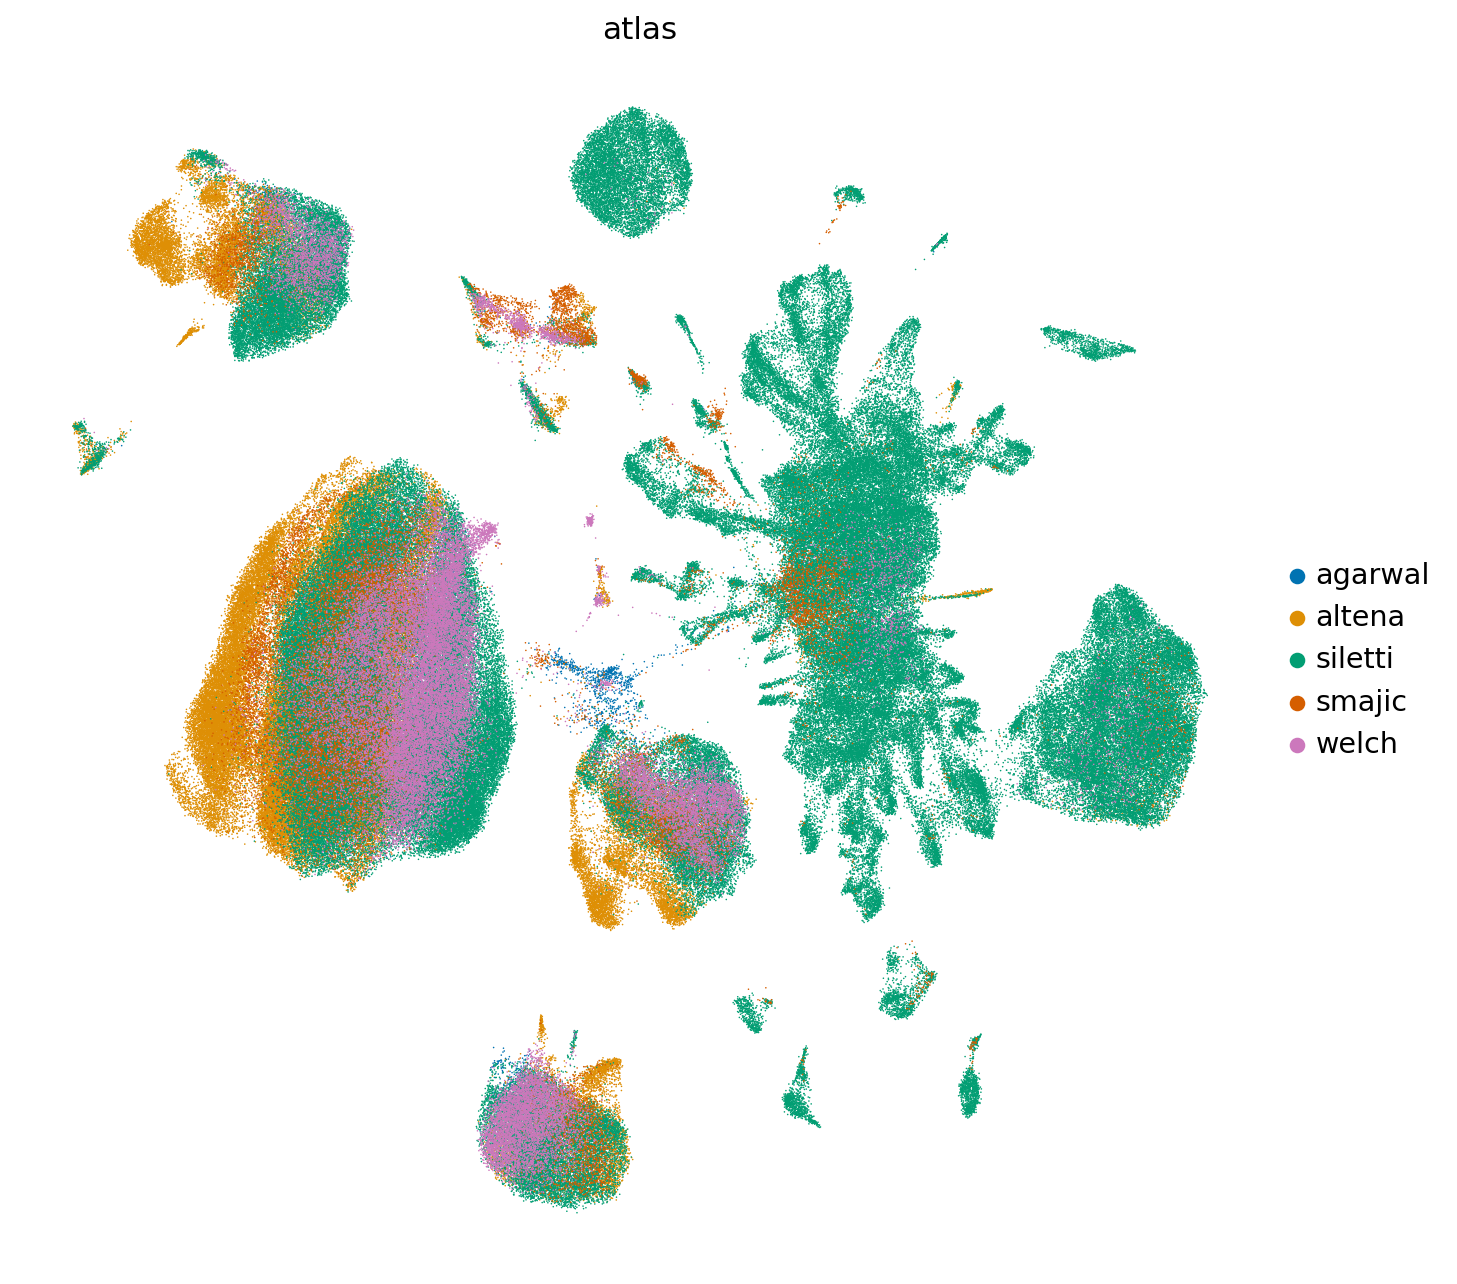

In [34]:
sc.settings.figdir ='/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final/'
sc.pl.umap(source_latent,
           color=['atlas'],
           frameon=False,
           wspace=0.6, s=2,
           palette=sns.color_palette('colorblind', as_cmap=True)[:5]
           #,save='_scvi_latent_atlas.png'
           )


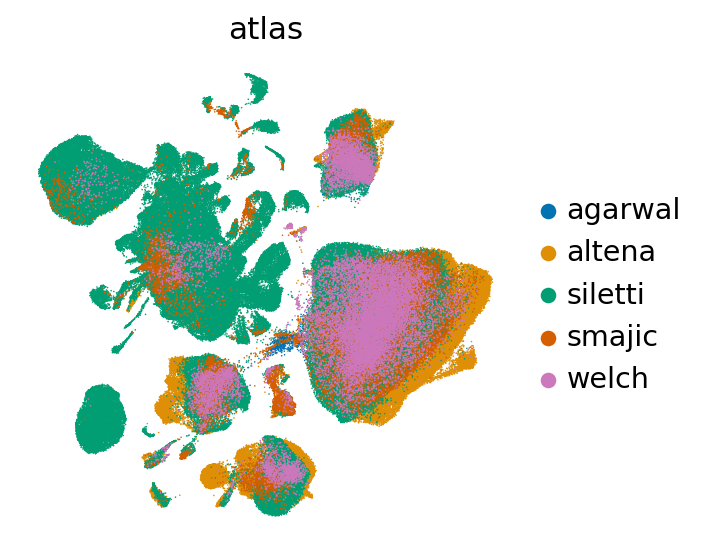

In [27]:
sc.settings.figdir =''
sc.pl.umap(source_latent,
           color=['atlas'],
           frameon=False,
           wspace=0.6, s=2,
           palette=sns.color_palette('colorblind', as_cmap=True)[:5]
           ,save='_scvi_latent_atlas.png'
           )


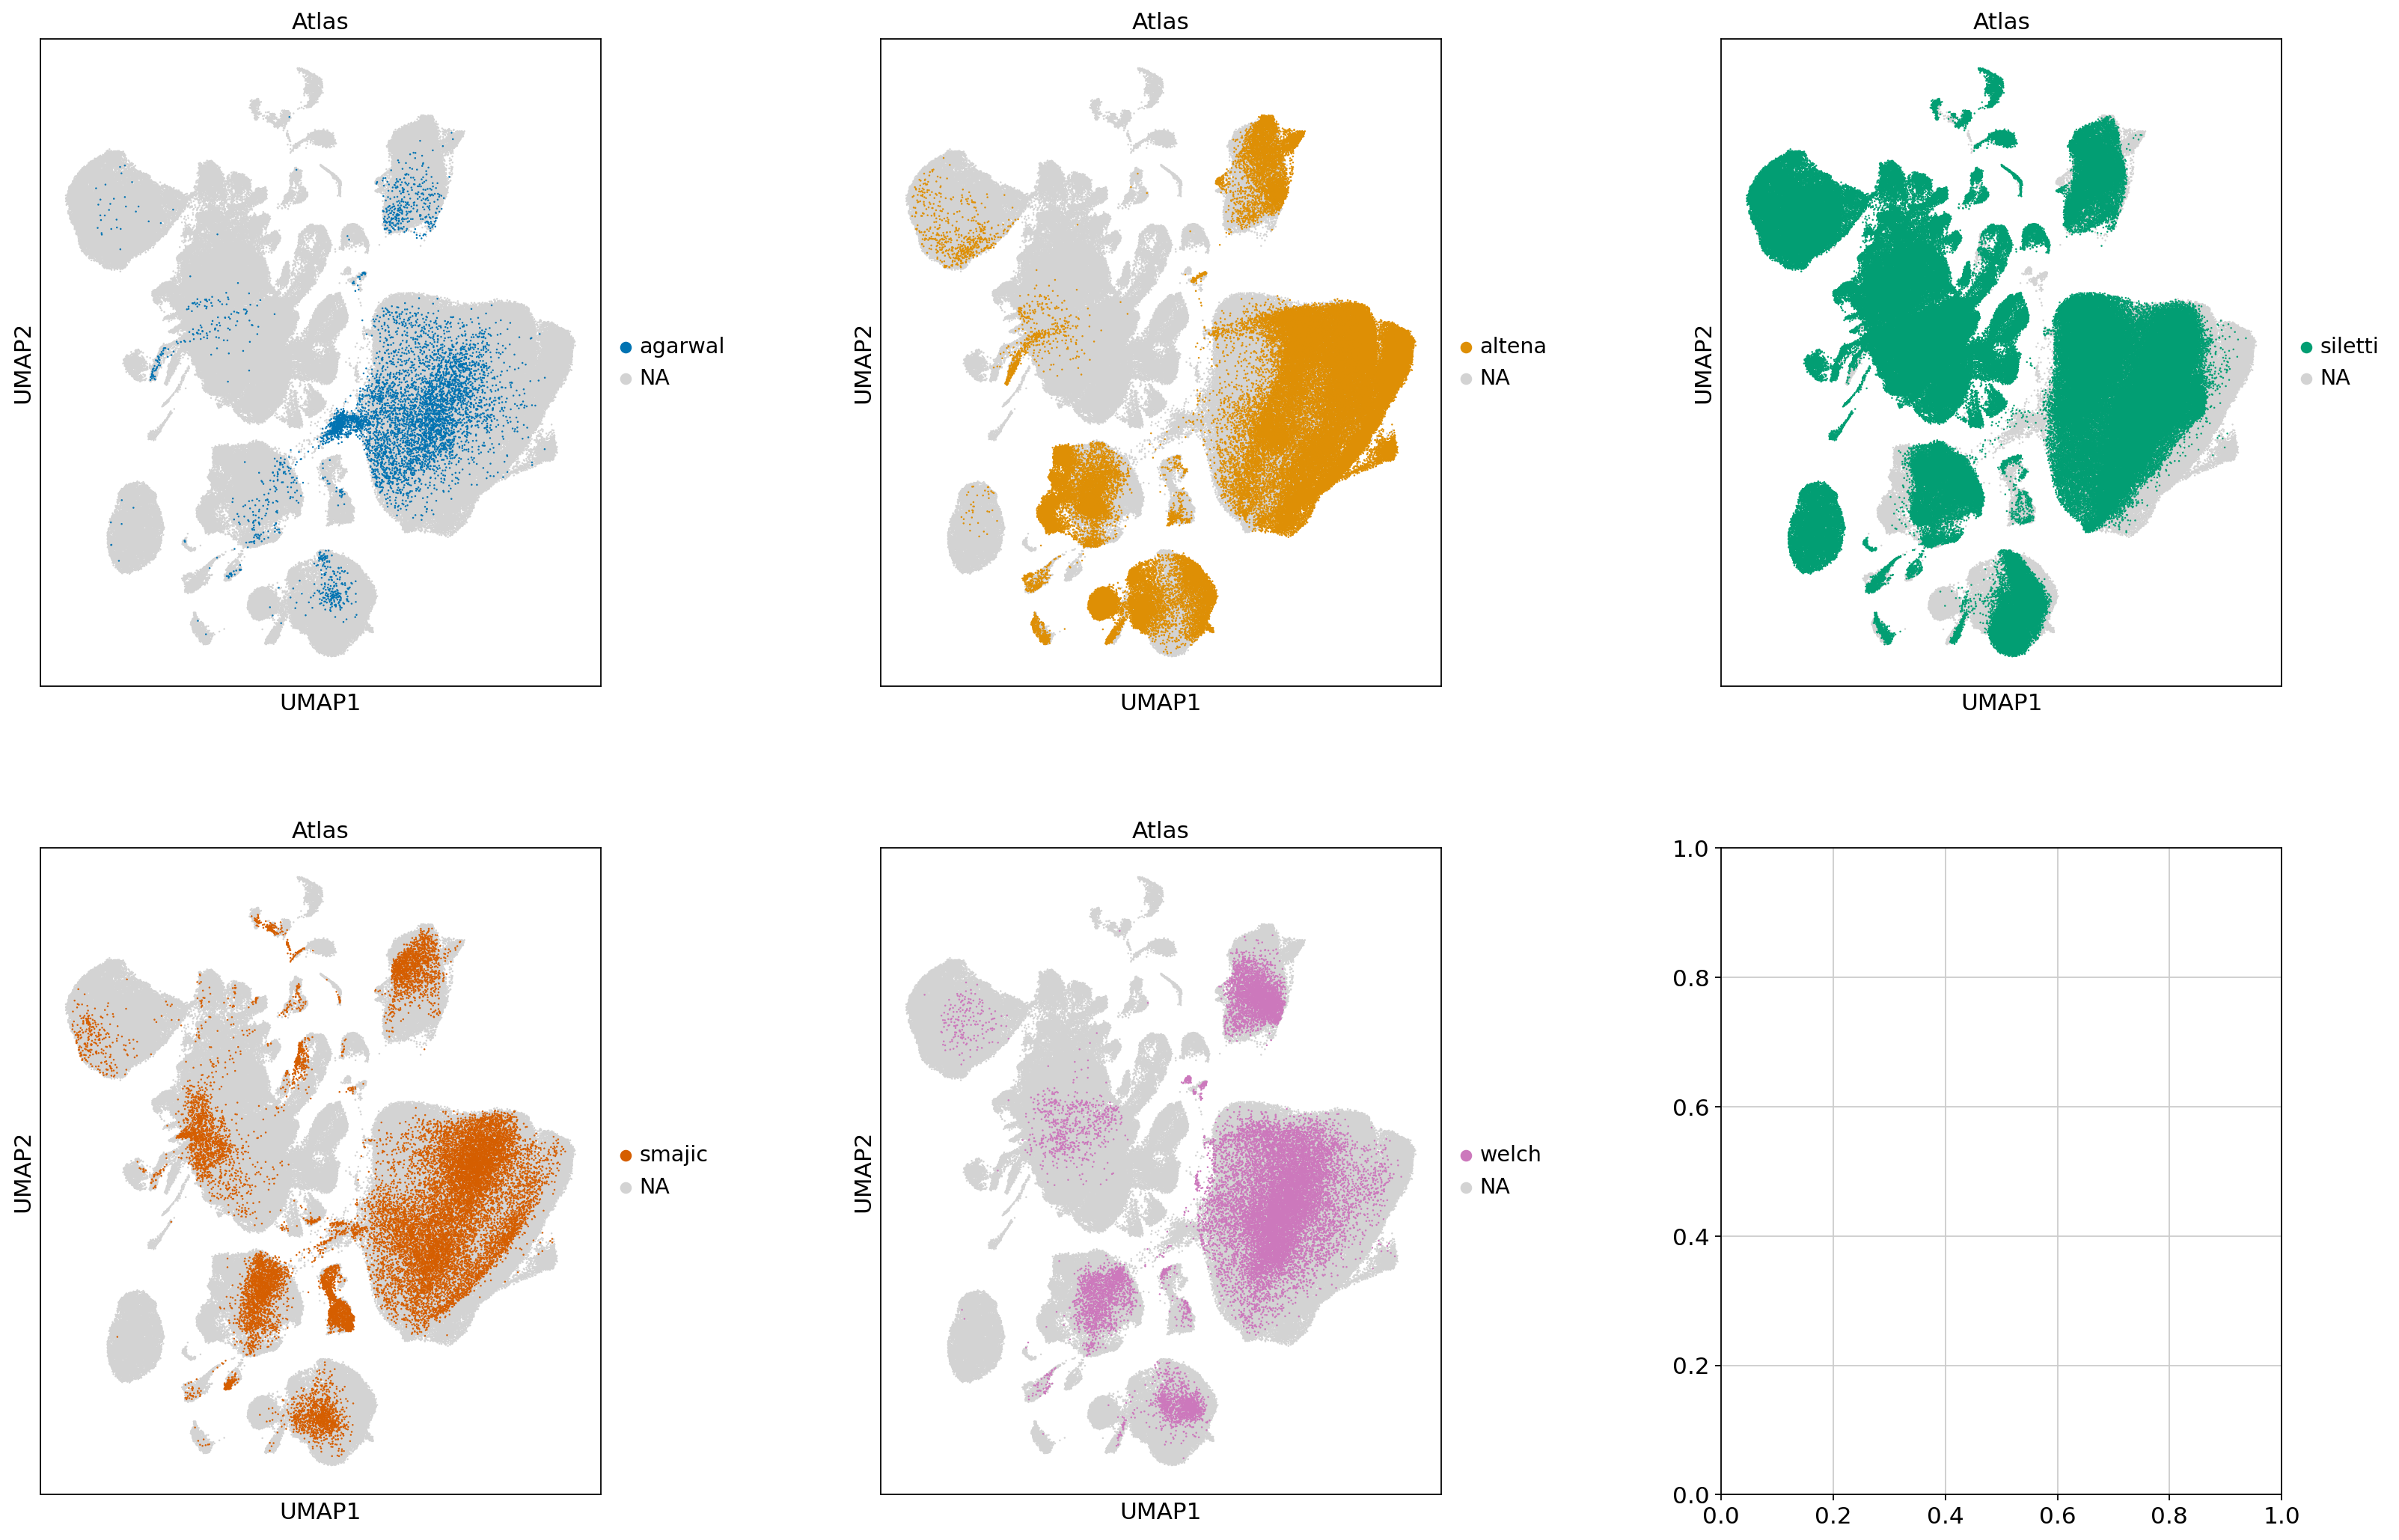

In [28]:
feature1='atlas'
title1='Atlas'

fig, axs = plt.subplots(2, 3, figsize = [24,16])
#axs[-1, -1].axis('off')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.25)
sc.pl.umap(source_latent, color=feature1, groups= 'agarwal', use_raw=False, s=5, ax= axs[0,0],show=False, title=title1,palette=sns.color_palette('colorblind', as_cmap=True))
sc.pl.umap(source_latent, color=feature1, groups= 'altena', use_raw=False, s=5, ax= axs[0,1],show=False, title=title1,palette=sns.color_palette('colorblind', as_cmap=True))
sc.pl.umap(source_latent, color=feature1, groups= 'siletti', use_raw=False, s=5, ax= axs[0,2],show=False, title=title1,palette=sns.color_palette('colorblind', as_cmap=True))
sc.pl.umap(source_latent, color=feature1, groups= 'smajic', use_raw=False, s=5, ax= axs[1,0],show=False, title=title1,palette=sns.color_palette('colorblind', as_cmap=True))
sc.pl.umap(source_latent, color=feature1, groups= 'welch', use_raw=False, s=5, ax= axs[1,1],show=False, title=title1,palette=sns.color_palette('colorblind', as_cmap=True))
fig.savefig(f'/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scarches/umap_scvi_latent_n30_r40_subplots.png',bbox_inches='tight')

Cell type per atlas

In [28]:
for s in np.unique(source_latent.obs.atlas):
    ref_s = cp.deepcopy(source_latent)
    ref_s.obs.cell_type_lvl1[source_latent.obs.atlas != s] = np.nan

    sc.pl.umap(ref_s,
               color=['cell_type_lvl1'],
               frameon=False,
               wspace=0.6, s=5,
               palette=sns.color_palette('colorblind', as_cmap=True), title=s,
               ,save='.pdf'
               )

SyntaxError: invalid syntax (3825368367.py, line 10)

# scHPL

In [15]:
source_latent=sc.read_h5ad('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final/adata_latent_all.h5ad')

In [16]:
source_latent

AnnData object with n_obs × n_vars = 522220 × 90
    obs: 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', 'sample', 'atlas', 'species', 'gender', 'age', 'instrument', 'technology', 'donor', 'cell_type_lowest_res', 'cell_type_low_res', 'cell_type_med_res', 'cell_type_high_res'

prepare labels (I made a more complete function in the scripts folder)

In [10]:
low=source_latent.obs['cell_type_lvl1'].tolist()
med=source_latent.obs['cell_type_lvl2'].tolist()
high=source_latent.obs['cell_type_lvl3'].tolist()
atlas=source_latent.obs['atlas'].tolist()

siletti_supercluster=['Miscellaneous', 'Microglia', 'Vascular', 'Fibroblast', 'Oligodendrocyte precursor', 'Committed oligodendrocyte precursor', 'Oligodendrocyte', 'Bergmann glia', 'Astrocyte', 'Ependymal', 'Choroid plexus', 'Deep-layer near-projecting', 'Deep-layer corticothalamic and 6b', 'Hippocampal CA1-3', 'Upper-layer intratelencephalic', 'Deep-layer intratelencephalic', 'Amygdala excitatory', 'Hippocampal CA4', 'Hippocampal dentate gyrus', 'Medium spiny neuron', 'Eccentric medium spiny neuron', 'Splatter', 'MGE interneuron', 'LAMP5-LHX6 and Chandelier', 'CGE interneuron', 'Upper rhombic lip', 'Cerebellar inhibitory', 'Lower rhombic lip', 'Mammillary body', 'Thalamic excitatory', 'Midbrain-derived inhibitory']
siletti_class=['MISC', 'MGL', 'ENDO', 'FIB', 'OPC', 'OLIGO', 'OLIGO', 'ASTRO', 'ASTRO', 'EPEN', 'CHRP', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR','NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR']

cell_type_lowest_res = list()
cell_type_low_res = list()
cell_type_med_res = list()
cell_type_high_res = list()

for i in range(len(source_latent.obs_names)):
    cell_type_low_res.append(str(low[i]).replace('_','-')) #low
    
    if atlas[i]!='siletti':
        if high[i]!= '':
            cell_type_high_res.append(str(high[i]).replace('_','-'))
            cell_type_med_res.append(str(high[i]).replace('_','-'))
        elif med[i]!= '':
            cell_type_high_res.append(str(med[i]).replace('_','-'))
            cell_type_med_res.append(str(med[i]).replace('_','-'))
        else:
            cell_type_high_res.append(str(low[i]).replace('_','-'))
            cell_type_med_res.append(str(low[i]).replace('_','-'))

    if atlas[i]=='siletti':
        cell_index=siletti_supercluster.index(low[i])
        cell_type_lowest_res.append(str(siletti_class[cell_index]).replace('_','-'))#lowest
        cell_type_high_res.append(str(high[i]).replace('_','-'))#high
        cell_type_med_res.append(str(med[i]).replace('_','-'))#med
    elif atlas[i]=='welch':

        if 'ASTRO' in low[i]:
            cell_type_lowest_res.append('ASTRO')#lowest
        elif 'ENDO' in low[i]:
            cell_type_lowest_res.append('ENDO')#lowest
        elif 'NEURO' in low[i]:
            cell_type_lowest_res.append('NEURO')#lowest
        elif 'OLIGO' in low[i]:
            cell_type_lowest_res.append('OLIGO')#lowest
        elif 'OPC' in low[i]:
            cell_type_lowest_res.append('OPC')#lowest
        elif 'MG' in low[i]:
            cell_type_lowest_res.append('MG')#lowest
    elif atlas[i]=='smajic':
        if 'DaNs' in low[i]:
            cell_type_lowest_res.append('Neuron')#lowest
        elif 'CADPS2+ neurons' in low[i]:
            cell_type_lowest_res.append('Neuron')#lowest
        elif 'Excitatory' in low[i]:
            cell_type_lowest_res.append('Neuron')#lowest
        elif 'GABA' in low[i]:
            cell_type_lowest_res.append('Neuron')#lowest
        elif 'Inhibitory' in low[i]:
            cell_type_lowest_res.append('Neuron')#lowest
        else:
            cell_type_lowest_res.append(low[i])#lowest
    elif atlas[i]=='agarwal':
        if 'DaN' in low[i]:
            cell_type_lowest_res.append('Neuron')#lowest
        elif 'GABA neurons' in low[i]:
            cell_type_lowest_res.append('Neuron')#lowest
        else:
            cell_type_lowest_res.append(low[i])#lowest
    else:
        cell_type_lowest_res.append(str(low[i]).replace('_','-'))#lowest
        #high and med
    
        
source_latent.obs['cell_type_lowest_res'] = cell_type_lowest_res
source_latent.obs['cell_type_low_res'] = cell_type_low_res
source_latent.obs['cell_type_med_res'] = cell_type_med_res
source_latent.obs['cell_type_high_res'] = cell_type_high_res

source_latent.obs['cell_type_high_res'] = np.char.add(np.char.add(np.array(source_latent.obs['cell_type_high_res'], dtype= str), '-'),
                                             np.array(source_latent.obs['atlas'], dtype=str))

source_latent.obs['cell_type_med_res'] = np.char.add(np.char.add(np.array(source_latent.obs['cell_type_med_res'], dtype= str), '-'),
                                             np.array(source_latent.obs['atlas'], dtype=str))

source_latent.obs['cell_type_low_res'] = np.char.add(np.char.add(np.array(source_latent.obs['cell_type_low_res'], dtype= str), '-'),
                                             np.array(source_latent.obs['atlas'], dtype=str))

source_latent.obs['cell_type_lowest_res'] = np.char.add(np.char.add(np.array(source_latent.obs['cell_type_lowest_res'], dtype= str), '-'),
                                             np.array(source_latent.obs['atlas'], dtype=str))




In [6]:
source_latent.obs['']

AnnData object with n_obs × n_vars = 378209 × 90
    obs: 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', 'sample', 'atlas', 'species', 'gender', 'age', 'instrument', 'technology', 'donor', 'cell_type_low_res', 'cell_type_med_res', 'cell_type_high_res'
    uns: 'atlas_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [14]:
source_latent.obs['cell_type_lowest_res'] = np.char.add(np.char.add(np.array(source_latent.obs['cell_type_lowest_res'], dtype= str), '-'),
                                             np.array(source_latent.obs['atlas'], dtype=str))

In [12]:
source_latent=source_latent[source_latent.obs['cell_type_low_res']!='']

Starting tree:


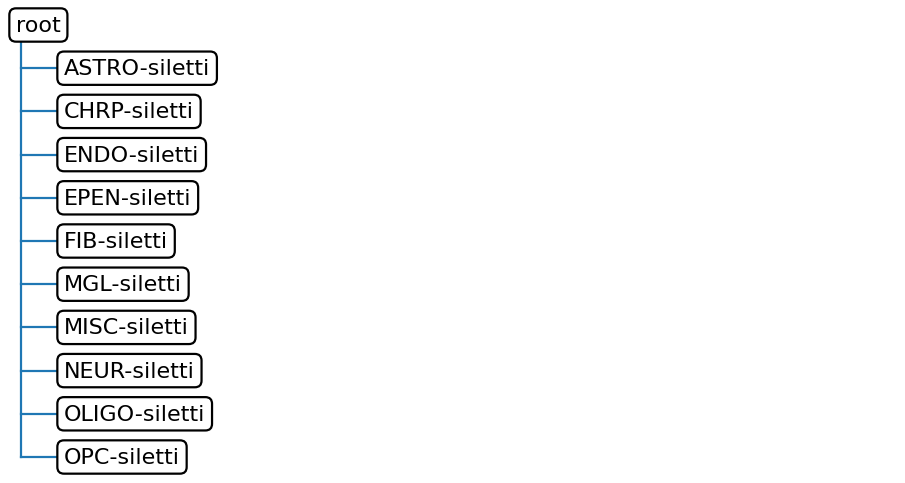


Adding dataset welch to the tree

Updated tree:


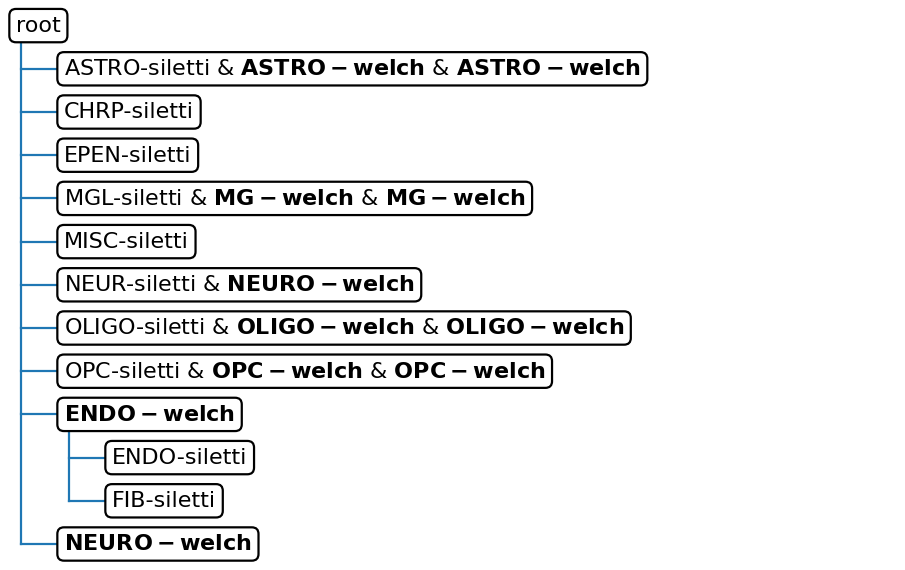


Adding dataset altena to the tree


In [ ]:

tree_ref, mp_ref = sca.classifiers.scHPL.learn_tree(data = source_latent,
                batch_key = 'atlas',
                batch_order = ['siletti',  'welch','altena', 'smajic', 'agarwal'],
                cell_type_key='cell_type_lowest_res',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False,attach_missing=True)

In [90]:
from scHPL.utils import TreeNode, _print_node, _count_nodes
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

def _print_node(node, hor, ver_steps, fig, new_nodes):
    global ver
    # Add horizontal line
    x, y = ([np.max([0.05, hor-0.045]), hor], [ver, ver])
    line = mlines.Line2D(x,y, lw=1)
    fig.add_artist(line)
    
    # Add textbox
    if np.isin(node.name[0], new_nodes):
        txt = r"$\bf{" + node.name[0] + "}$"
    else:
        txt = node.name[0]
    
    for n in node.name:
        if(n != node.name[0]):
            if np.isin(n, new_nodes):
                txt = txt + ' & ' + r"$\bf{" + n + "}$"
            else:
                txt = txt + ' & ' + n
                
    fig.text(hor,ver, txt, size=10,
             ha = 'left', va='center',
             bbox = dict(boxstyle='round', fc='w', ec='k'))
    
    # Continue with child nodes
    hor = hor+0.05
    ver_line_start = ver
    ver_line_end = ver
    
    for i in node.descendants:
        ver = ver-ver_steps
        ver_line_end = ver
        _print_node(i, hor, ver_steps, fig, new_nodes)
        
    # Add vertical line
    x, y = ([np.max([0.05, hor-0.045]), np.max([0.05, hor-0.045])], 
            [ver_line_start, ver_line_end])
    line = mlines.Line2D(x,y, lw=1)
    fig.add_artist(line)


def print_tree(tree: TreeNode, 
               new_nodes: list = []):
    '''Print the tree
        Parameters
        ----------
        tree : TreeNode
            Tree to print
        new_nodes : List = []
            Nodes recently added to the tree, these are printed in bold
    
        Returns
        -------
        None.
    '''
    
    global ver
    ver = 0.93
    
    count = _count_nodes(tree)
    ver_steps = 0.9/count
    plot_height = count*0.3
    fig = plt.figure(figsize=(15,plot_height)) # This size is hard coded
    ax = plt.subplot(111)

    _print_node(tree[0], hor=0.05, ver_steps=ver_steps, fig=fig, 
                new_nodes = new_nodes)
    
    plt.axis('off')
    plt.savefig('/home/hers_basak/jjiang/jack/outputs/deliverables/6_analysis/tree_ref_astro_high_5.pdf', dpi=1000,bbox_inches='tight')
    plt.close()

In [91]:
import pickle
with open('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_astro_all/tree_ref_high_5.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    tree_ref = pickle.load(file) 
  
    print_tree(tree_ref) 

In [95]:
print_tree(tree_ref)

In [47]:

with open('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final/tree_ref_lowest.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    tree_ref = pickle.load(file) 
  
    print_tree(tree_ref) 

In [86]:
print_tree(tree_ref)

In [8]:
with open('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/mp_ref_high.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    mp_ref = pickle.load(file) 
  
    print(mp_ref)

['Neuron-DOPA-1-altena', 'Neuron-DOPA-GABA-GLUT-1-altena', 'Neuron-GABA-1-altena', 'Neuron-GABA-2-altena', 'Neuron-GABA-3-altena', 'Neuron-GABA-4-altena', 'Neuron-GABA-5-altena', 'Neuron-GABA-6-altena', 'Neuron-GABA-8-altena', 'Neuron-GABA-9-altena', 'Neuron-GABA-DOPA-1-altena', 'Neuron-GABA-DOPA-2-altena', 'Neuron-GABA-DOPA-3-altena', 'Neuron-GABA-DOPA-4-altena', 'Neuron-GABA-GLUT-1-altena', 'Neuron-GABA-GLUT-2-altena', 'Neuron-unknown-1-altena', 'Neuron-unknown-2-altena', '"NEUROex1"-welch', '"NEUROinh3"-welch', 'GABA-smajic', 'Inhibitory-smajic']


In [13]:
import scanpy as sc

In [15]:
source_latent=sc.read_h5ad('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/adata_latent.h5ad')


In [17]:
source_latent

AnnData object with n_obs × n_vars = 130101 × 90
    obs: 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', 'sample', 'atlas', 'species', 'gender', 'age', 'instrument', 'technology', 'donor', 'cell_type_lowest_res', 'cell_type_low_res', 'cell_type_med_res', 'cell_type_high_res'

In [9]:
for i in mp_ref:
    print(i)

Neuron-DOPA-1-altena
Neuron-DOPA-GABA-GLUT-1-altena
Neuron-GABA-1-altena
Neuron-GABA-2-altena
Neuron-GABA-3-altena
Neuron-GABA-4-altena
Neuron-GABA-5-altena
Neuron-GABA-6-altena
Neuron-GABA-8-altena
Neuron-GABA-9-altena
Neuron-GABA-DOPA-1-altena
Neuron-GABA-DOPA-2-altena
Neuron-GABA-DOPA-3-altena
Neuron-GABA-DOPA-4-altena
Neuron-GABA-GLUT-1-altena
Neuron-GABA-GLUT-2-altena
Neuron-unknown-1-altena
Neuron-unknown-2-altena
"NEUROex1"-welch
"NEUROinh3"-welch
GABA-smajic
Inhibitory-smajic


In [77]:
source_latent=sc.read_h5ad('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/adata_latent.h5ad')

In [83]:
all=sc.read_h5ad('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final/adata_predicted_neuron_all.h5ad')

In [44]:
celltypes=source_latent.obs['cell_type_high_res'].tolist()
small_labels=list()

for i in set(celltypes):
    count = celltypes.count(i)
    if count<=5:
        small_labels.append(i)
    if 'altena' in i:
        print(i+ ": "+str(count))

Neuron-GABA-DOPA-2-altena: 8
Neuron-GABA-7-altena: 91
Neuron-unknown-2-altena: 21
Neuron-DOPA-GABA-GLUT-1-altena: 33
Neuron-GABA-5-altena: 21
Neuron-GABA-2-altena: 63
Neuron-GABA-10-altena: 116
Neuron-DOPA-1-altena: 101
Neuron-GABA-DOPA-1-altena: 13
Neuron-GABA-8-altena: 61
Neuron-GABA-6-altena: 45
Neuron-GABA-1-altena: 50
Neuron-GABA-GLUT-1-altena: 249
Neuron-GABA-9-altena: 63
Neuron-GABA-3-altena: 45
Neuron-GABA-11-altena: 206
Neuron-GABA-GLUT-2-altena: 35
Neuron-GABA-DOPA-4-altena: 30
Neuron-DOPA-GLUT-1-altena: 88
Neuron-unknown-1-altena: 16
Neuron-GABA-4-altena: 29
Neuron-GABA-DOPA-3-altena: 99


In [94]:
source_latent_labels5=source_latent[~source_latent.obs['cell_type_high_res'].isin(small_labels)]

In [96]:
source_latent_labels5.write('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/adata_latent_labels5.h5ad')

In [95]:
source_latent_labels5

View of AnnData object with n_obs × n_vars = 128918 × 90
    obs: 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', 'sample', 'atlas', 'species', 'gender', 'age', 'instrument', 'technology', 'donor', 'cell_type_lowest_res', 'cell_type_low_res', 'cell_type_med_res', 'cell_type_high_res'

In [89]:
celltypes=source_latent.obs['cell_type_high_res'].tolist()

for i in set(celltypes):
    if 'altena' in i:
        print(i+ ": "+str(celltypes.count(i)))

Neuron-GABA-10-altena: 116
Neuron-GABA-7-altena: 91
Neuron-DOPA-1-altena: 101
Neuron-GABA-8-altena: 61
Neuron-GABA-5-altena: 21
Neuron-GABA-6-altena: 45
Neuron-GABA-11-altena: 206
Neuron-GABA-DOPA-4-altena: 30
Neuron-unknown-1-altena: 16
Neuron-GABA-1-altena: 50
Neuron-DOPA-GLUT-1-altena: 88
Neuron-GABA-4-altena: 29
Neuron-unknown-2-altena: 21
Neuron-DOPA-GABA-GLUT-1-altena: 33
Neuron-GABA-3-altena: 45
Neuron-GABA-9-altena: 63
Neuron-GABA-GLUT-2-altena: 35
Neuron-GABA-DOPA-1-altena: 13
Neuron-GABA-DOPA-3-altena: 99
Neuron-GABA-2-altena: 63
Neuron-GABA-GLUT-1-altena: 249
Neuron-GABA-DOPA-2-altena: 8


In [72]:
import pickle
with open('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/tree_ref_med.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    tree_ref = pickle.load(file) 
  
    print_tree(tree_ref) 

In [23]:
tree_ref[0].descendants

[Node("['197-siletti']"),
 Node("['198-siletti']"),
 Node("['236-siletti']"),
 Node("['237-siletti']"),
 Node("['239-siletti']"),
 Node("['240-siletti']"),
 Node("['250-siletti']"),
 Node("['251-siletti']"),
 Node("['252-siletti']"),
 Node("['254-siletti']"),
 Node("['255-siletti']"),
 Node("['256-siletti']"),
 Node("['257-siletti']"),
 Node("['258-siletti']"),
 Node("['259-siletti']"),
 Node("['260-siletti']"),
 Node("['261-siletti']"),
 Node("['262-siletti']"),
 Node("['263-siletti']"),
 Node("['264-siletti']"),
 Node("['265-siletti']"),
 Node("['266-siletti']"),
 Node("['267-siletti']"),
 Node("['268-siletti']"),
 Node("['269-siletti']"),
 Node("['270-siletti']"),
 Node("['271-siletti']"),
 Node("['272-siletti']"),
 Node("['273-siletti']"),
 Node("['274-siletti']"),
 Node("['275-siletti']"),
 Node("['284-siletti']"),
 Node("['286-siletti']"),
 Node("['287-siletti']"),
 Node("['288-siletti']"),
 Node("['295-siletti']"),
 Node("['296-siletti']"),
 Node("['334-siletti']"),
 Node("['364

In [24]:
import pickle
with open('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/mp_ref_med.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    mp_ref = pickle.load(file) 
  

In [25]:
mp_ref

['Neuron-DOPA-1-altena',
 'Neuron-DOPA-GABA-GLUT-1-altena',
 'Neuron-GABA-1-altena',
 'Neuron-GABA-10-altena',
 'Neuron-GABA-11-altena',
 'Neuron-GABA-2-altena',
 'Neuron-GABA-3-altena',
 'Neuron-GABA-4-altena',
 'Neuron-GABA-5-altena',
 'Neuron-GABA-6-altena',
 'Neuron-GABA-8-altena',
 'Neuron-GABA-9-altena',
 'Neuron-GABA-DOPA-1-altena',
 'Neuron-GABA-DOPA-2-altena',
 'Neuron-GABA-DOPA-3-altena',
 'Neuron-GABA-DOPA-4-altena',
 'Neuron-GABA-GLUT-1-altena',
 'Neuron-GABA-GLUT-2-altena',
 'Neuron-unknown-1-altena',
 'Neuron-unknown-2-altena',
 'Inhibitory-smajic',
 'DaNs-agarwal']

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

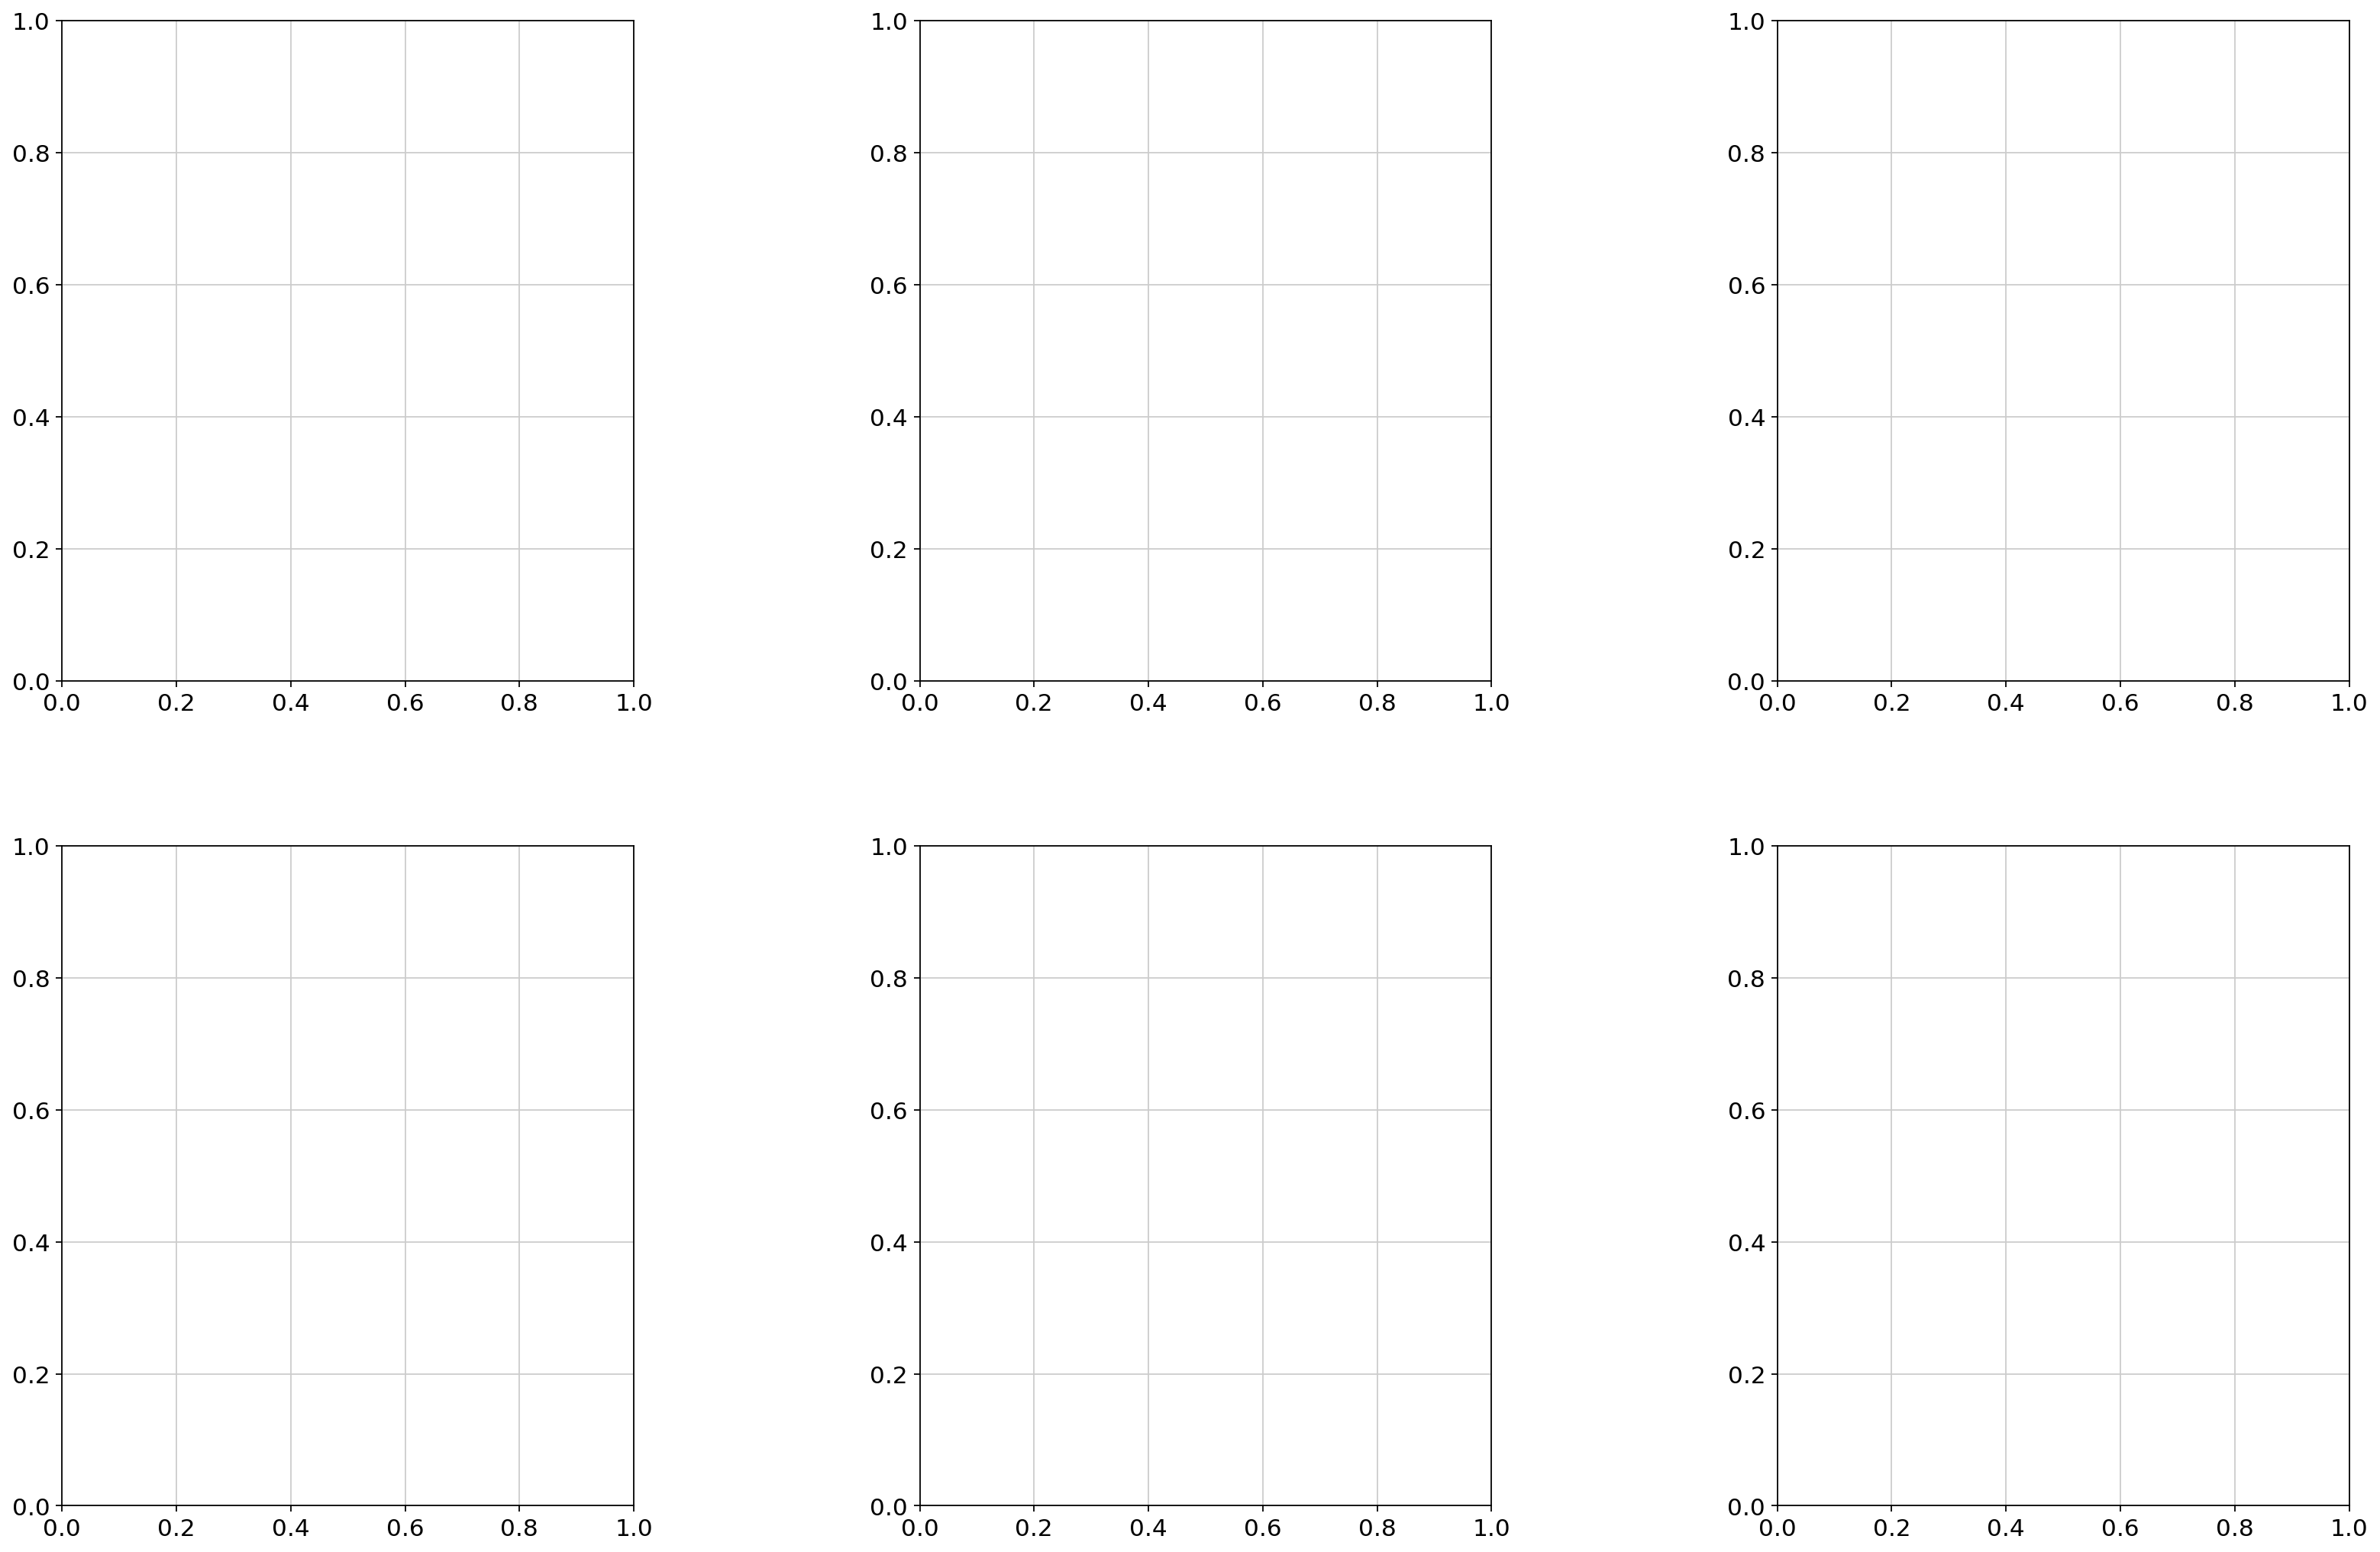

In [14]:
feature1='cell_type_lowest_res'
title1='celltype low res'

fig, axs = plt.subplots(2, 3, figsize = [24,16])
#axs[-1, -1].axis('off')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.25)
sc.pl.umap(source_latent, color=feature1, groups= 'Endothelial-agarwal', use_raw=False, s=5, ax= axs[0,0],show=False, title=title1,palette=sns.color_palette('colorblind', as_cmap=True))
sc.pl.umap(source_latent, color=feature1, groups= 'Endothelial-altena', use_raw=False, s=5, ax= axs[0,1],show=False, title=title1,palette=sns.color_palette('colorblind', as_cmap=True))
sc.pl.umap(source_latent, color=feature1, groups= 'NEURO-welch', use_raw=False, s=5, ax= axs[0,2],show=False, title=title1,palette=sns.color_palette('colorblind', as_cmap=True))
sc.pl.umap(source_latent, color=feature1, groups= 'NEUR-siletti', use_raw=False, s=5, ax= axs[1,0],show=False, title=title1,palette=sns.color_palette('colorblind', as_cmap=True))
#sc.pl.umap(source_latent, color=feature1, groups= 'ENDO-welch', use_raw=False, s=5, ax= axs[1,1],show=False, title=title1,palette=sns.color_palette('colorblind', as_cmap=True))

## Label harmonization
The scHPL Tree Node class is based on the Node class of the Newick Python package. Currently there are no scHPL methods that allow easy parsing through the tree and all nodes. This would be nice for convenient harmonization of labels. That being said, Newick Nodes have plenty of attributes that can be used for this. See https://github.com/dlce-eva/python-newick/blob/master/src/newick.py 

In [8]:
#import scHPL
import newick


The Tree Node itself is a list with only the root, accessing this and its (Node) attributes is done by indexing the first element.

In [9]:
tree_ref[0]

Node("['root']")

You can parse through these by indexing the descendants nodes

In [10]:
tree_ref[0].descendants

[Node("['197-siletti']"),
 Node("['198-siletti']"),
 Node("['236-siletti']"),
 Node("['237-siletti']"),
 Node("['239-siletti']"),
 Node("['240-siletti']"),
 Node("['250-siletti']"),
 Node("['251-siletti']"),
 Node("['252-siletti']"),
 Node("['254-siletti']"),
 Node("['255-siletti']"),
 Node("['256-siletti']"),
 Node("['257-siletti']"),
 Node("['258-siletti']"),
 Node("['259-siletti']"),
 Node("['260-siletti']"),
 Node("['261-siletti']"),
 Node("['262-siletti']"),
 Node("['263-siletti']"),
 Node("['264-siletti']"),
 Node("['265-siletti']"),
 Node("['266-siletti']"),
 Node("['267-siletti']"),
 Node("['268-siletti']"),
 Node("['269-siletti']"),
 Node("['270-siletti']"),
 Node("['271-siletti']"),
 Node("['272-siletti']"),
 Node("['273-siletti']"),
 Node("['274-siletti']"),
 Node("['275-siletti']"),
 Node("['284-siletti']"),
 Node("['286-siletti']"),
 Node("['287-siletti']"),
 Node("['288-siletti']"),
 Node("['295-siletti']"),
 Node("['296-siletti']"),
 Node("['334-siletti']"),
 Node("['364

To get the list of strings that make up the node name, use ".name" attribute of the Node class

In [9]:
tree_ref[0].descendants[15].name

IndexError: list index out of range

In [17]:
def descend(nodes): 
    """Get the right resolution of labels -> List(str)
    
    Parameters
    -------------------------------------------------------------
    nodes: List[node]
        List of descendants nodes of the label node that you want to use as harmonized label
    
    return
    -----------------------------------------------------------------
    List of nested lists that represent all the node names that fall under the first layer of nodes.
    """
    labels=list()
    for node in nodes:
        for name in node.name:
            labels.append(name)
        if node.descendants==[]:
            continue
        else:         
            for name in descend(node.descendants):
                labels.append(name)
    return labels
    
    

In [22]:
def get_label_descendants(tree,level):
    """Gets the descendants at a certain level for all branches and subbranches
    
    Parameters
    --------------------------------------------------------------------------
    tree: TreeNode 
            Classification tree to take equivalent labels from (resulting from learn_tree method)
    level: Int
            Which tree depth to use to harmonize the labels (0=root only, 1: first descendants)
    
    return
    -----------------------------------------------------
    A list of nodes at a certain level
    """
    nodes=list()
    if level == 0:
        return tree
    for branch in tree.descendants:
        nodes.append(get_label_descendants(branch,level-1))
    return nodes

In [21]:
    
def harmonize_labels(adata,label_key,tree,level,new_key='harmonized_cell_type'):
    
    """Changes the labels to equivalent onces in all batches.
    
    Parameters
    ------------------------------------------------------
    adata: Anndata object
            Object containing the expression data as well as annotations and latent space
    label_key: str
            String for the key of the cell_type annotation that needs to be harmonized
    tree: TreeNode 
            Classification tree to take equivalent labels from (resulting from learn_tree method)
    batches: List[str]
            List of batch keys (also used for priority order in which labels is taken, need to have batch keys as suffix)
    level: Int
            Which tree depth to use to harmonize the labels (0=root only, 1: first descendants)
    new_key: str
            The new key where the harmonized cell labels will be
    return
    -------------------------------------------------------
    None, but original Anndata object will gain .obs['harmonized_celltype'] feature
    """
    
    descendants = get_label_descendants(tree[0],level)
    old_labels=list()
    new_labels=list()
    for node in descendants:
        old_labels.append(descend(node.descendants))
        node_name=node.name
        for name in node_name:
            old_labels[-1].append(name)
        new_labels.append(node_name[0])
    
    new_values=list()
    for original in adata.obs[label_key].tolist():
        unknown=True
        for i in range(len(old_labels)):
            if original in old_labels[i]:
                new_values.append(new_labels[i])
                unknown=False
                break
        if unknown ==True:
            new_values.append('unknown')
            
                
    adata.obs[new_key]=new_values
    
    return adata
    

In [15]:
a = set(source_latent.obs["cell_type_lowest_res"].tolist())
cell_type_low_res_batch=source_latent.obs["cell_type_lowest_res"].tolist()
for i in a:
    c=0
    for j in cell_type_low_res_batch:
        if j == i:
            c+=1
    print(f'{i}: {c}')
    

NEURO-welch: 1984
OLIGO-welch: 23672
T-Cell-altena: 426
PVM-altena: 313
OPC-welch: 6063
Perivascular-altena: 385
ENDO-welch: 933
MG-welch: 2447
EPEN-siletti: 271
Endothelial-altena: 254
Endothelial-agarwal: 72
NEUR-siletti: 123553
Oligodendrocyte-altena: 55731
FIB-siletti: 699
Microglia-altena: 10656
ASTRO-welch: 4760
Astrocytes-agarwal: 630
Microglia-agarwal: 324
OPC-altena: 5259
Astrocytes-smajic: 2130
OPCs-smajic: 1535
Pericytes-smajic: 652
Endothelial cells-smajic: 990
Astrocyte-altena: 8631
Neuron-altena: 1483
ENDO-siletti: 634
OPC-agarwal: 427
Neuron-agarwal: 195
CHRP-siletti: 3
Oligodendrocytes-smajic: 12691
Ependymal-smajic: 208
OLIGO-siletti: 79553
MGL-siletti: 14177
MISC-siletti: 1684
Microglia-smajic: 1187
Neuron-smajic: 2886
ODC-agarwal: 4255
ASTRO-siletti: 13276
OPC-siletti: 11765


In [17]:
a = set(source_latent.obs["cell_type_low_res"].tolist())
cell_type_low_res_batch=source_latent.obs["cell_type_low_res"].tolist()
for i in a:
    c=0
    for j in cell_type_low_res_batch:
        if j == i:
            c+=1
    print(f'{i}: {c}')
    

DaNs-smajic: 30
"ENDOmural"-welch: 89
Perivascular-altena: 385
"MGfos"-welch: 606
"NEUROdop"-welch: 77
OPC-agarwal: 427
OPCs-smajic: 1535
Oligodendrocyte-siletti: 79422
"MGmp"-welch: 70
Microglia-altena: 10656
"OLIGO2"-welch: 2843
OPC-altena: 5259
Endothelial cells-smajic: 990
Hippocampal CA1-3-siletti: 3
Pericytes-smajic: 652
PVM-altena: 313
Deep-layer intratelencephalic-siletti: 18
"OLIGO1"-welch: 3454
Eccentric medium spiny neuron-siletti: 1
Inhibitory-smajic: 792
Astrocyte-altena: 8631
"OLIGO3"-welch: 2918
Hippocampal CA4-siletti: 49
Upper rhombic lip-siletti: 9188
T-Cell-altena: 426
Microglia-siletti: 14177
DaN-agarwal: 72
"NEUROinh3"-welch: 194
CGE interneuron-siletti: 686
Astrocytes-smajic: 2130
Oligodendrocyte-altena: 55731
Astrocytes-agarwal: 630
Microglia-smajic: 1187
Medium spiny neuron-siletti: 5
GABA-smajic: 275
Bergmann glia-siletti: 29
Ependymal-siletti: 271
Deep-layer corticothalamic and 6b-siletti: 60
"ASTRO"-welch: 738
"OLIGO4"-welch: 2903
Amygdala excitatory-siletti:

In [18]:
source_complete=sc.read_h5ad('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/adata.h5ad')

In [19]:
source_complete

AnnData object with n_obs × n_vars = 130101 × 2000
    obs: 'species', 'gender', 'age', 'instrument', 'technology', 'atlas', 'sample', 'batch_1', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'total_counts_mito', 'total_counts_norm', 'original_Library', 'original_Brain_Region', 'original_Level_1_cell_type', 'original_Level_2_cell_type', 'original_cellclass_lvl1', 'original_subclass_lvl3_1', 'original_cellclass_lvl1_n', 'original_lineage', 'original_subclass_lvl2', 'original_celltype_lvl3', 'donor', 'original_supercluster_term', 'original_cluster_id', 'original_subcluster_id', 'original_celltype', 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_low_res', 'cell_type_high_res', 'harmonized_cell_type', 'harmonized_lowes

Adding high and low resolution cell labels

In [16]:
def prepare_labels(adata):    
    low=adata.obs['cell_type_lvl1'].tolist()
    med=adata.obs['cell_type_lvl2'].tolist()
    high=adata.obs['cell_type_lvl3'].tolist()
    atlas=adata.obs['atlas'].tolist()

    siletti_supercluster=['Miscellaneous', 'Microglia', 'Vascular', 'Fibroblast', 'Oligodendrocyte precursor', 'Committed oligodendrocyte precursor', 'Oligodendrocyte', 'Bergmann glia', 'Astrocyte', 'Ependymal', 'Choroid plexus', 'Deep-layer near-projecting', 'Deep-layer corticothalamic and 6b', 'Hippocampal CA1-3', 'Upper-layer intratelencephalic', 'Deep-layer intratelencephalic', 'Amygdala excitatory', 'Hippocampal CA4', 'Hippocampal dentate gyrus', 'Medium spiny neuron', 'Eccentric medium spiny neuron', 'Splatter', 'MGE interneuron', 'LAMP5-LHX6 and Chandelier', 'CGE interneuron', 'Upper rhombic lip', 'Cerebellar inhibitory', 'Lower rhombic lip', 'Mammillary body', 'Thalamic excitatory', 'Midbrain-derived inhibitory']
    siletti_class=['MISC', 'MGL', 'ENDO', 'FIB', 'OPC', 'OLIGO', 'OLIGO', 'ASTRO', 'ASTRO', 'EPEN', 'CHRP', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR','NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR', 'NEUR']

    cell_type_lowest_res = list()
    cell_type_low_res = list()
    cell_type_med_res = list()
    cell_type_high_res = list()

    for i in range(len(adata.obs_names)):
        cell_type_low_res.append(str(low[i]).replace('_','-')) #low

        if atlas[i]!='siletti':
            if high[i]!= '':
                cell_type_high_res.append(str(high[i]).replace('_','-'))
                cell_type_med_res.append(str(high[i]).replace('_','-'))
            elif med[i]!= '':
                cell_type_high_res.append(str(med[i]).replace('_','-'))
                cell_type_med_res.append(str(med[i]).replace('_','-'))
            else:
                cell_type_high_res.append(str(low[i]).replace('_','-'))
                cell_type_med_res.append(str(low[i]).replace('_','-'))

        if atlas[i]=='siletti':
            cell_index=siletti_supercluster.index(low[i])
            cell_type_lowest_res.append(str(siletti_class[cell_index]).replace('_','-'))#lowest
            cell_type_high_res.append(str(high[i]).replace('_','-'))#high
            cell_type_med_res.append(str(med[i]).replace('_','-'))#med
        elif atlas[i]=='welch':

            if 'ASTRO' in low[i]:
                cell_type_lowest_res.append('ASTRO')#lowest
            elif 'ENDO' in low[i]:
                cell_type_lowest_res.append('ENDO')#lowest
            elif 'NEURO' in low[i]:
                cell_type_lowest_res.append('NEURO')#lowest
            elif 'OLIGO' in low[i]:
                cell_type_lowest_res.append('OLIGO')#lowest
            elif 'OPC' in low[i]:
                cell_type_lowest_res.append('OPC')#lowest
            elif 'MG' in low[i]:
                cell_type_lowest_res.append('MG')#lowest
        elif atlas[i]=='smajic':
            if 'DaNs' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            elif 'CADPS2+ neurons' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            elif 'Excitatory' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            elif 'GABA' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            elif 'Inhibitory' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            else:
                cell_type_lowest_res.append(low[i])#lowest
        elif atlas[i]=='agarwal':
            if 'DaN' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            elif 'GABA neurons' in low[i]:
                cell_type_lowest_res.append('Neuron')#lowest
            else:
                cell_type_lowest_res.append(low[i])#lowest
        else:
            cell_type_lowest_res.append(str(low[i]).replace('_','-'))#lowest
            #high and med


    adata.obs['cell_type_lowest_res'] = cell_type_lowest_res
    adata.obs['cell_type_low_res'] = cell_type_low_res
    adata.obs['cell_type_med_res'] = cell_type_med_res
    adata.obs['cell_type_high_res'] = cell_type_high_res

    adata.obs['cell_type_high_res'] = np.char.add(np.char.add(np.array(adata.obs['cell_type_high_res'], dtype= str), '-'),
                                                 np.array(adata.obs['atlas'], dtype=str))

    adata.obs['cell_type_med_res'] = np.char.add(np.char.add(np.array(adata.obs['cell_type_med_res'], dtype= str), '-'),
                                                 np.array(adata.obs['atlas'], dtype=str))

    adata.obs['cell_type_low_res'] = np.char.add(np.char.add(np.array(adata.obs['cell_type_low_res'], dtype= str), '-'),
                                                 np.array(adata.obs['atlas'], dtype=str))

    adata.obs['cell_type_lowest_res'] = np.char.add(np.char.add(np.array(adata.obs['cell_type_lowest_res'], dtype= str), '-'),
                                                 np.array(adata.obs['atlas'], dtype=str))


In [17]:
prepare_labels(source_complete)

In [24]:
adata_harmonized=harmonize_labels(adata=source_complete,label_key='cell_type_med_res',tree=tree_ref,level=1,new_key='harmonized_med_res')

In [28]:
source_complete.write('/home/hers_basak/jjiang/jack/outputs/deliverables/5_integration/data/scvi/models/scvi_model_final_neuron/adata_harmonized.h5ad')

In [26]:
source_complete

AnnData object with n_obs × n_vars = 130101 × 2000
    obs: 'species', 'gender', 'age', 'instrument', 'technology', 'atlas', 'sample', 'batch_1', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'total_counts_mito', 'total_counts_norm', 'original_Library', 'original_Brain_Region', 'original_Level_1_cell_type', 'original_Level_2_cell_type', 'original_cellclass_lvl1', 'original_subclass_lvl3_1', 'original_cellclass_lvl1_n', 'original_lineage', 'original_subclass_lvl2', 'original_celltype_lvl3', 'donor', 'original_supercluster_term', 'original_cluster_id', 'original_subcluster_id', 'original_celltype', 'cell_type_lvl1', 'cell_type_lvl2', 'cell_type_lvl3', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_low_res', 'cell_type_high_res', 'harmonized_cell_type', 'harmonized_lowes